In [1]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from matplotlib import pyplot as plt
from ast import literal_eval

In [2]:
# Import dataset
df = pd.read_csv("lda_labeled_master.csv")
df = df.rename(columns={"Unnamed: 0": "id"})
df.head()

,id,subject,from,date,to,label,thread,time,hour,month,...,subjectivity,num_qm,num_em,hashtag,prop_upper,num_full_upper,num_repeated,matrix,scores,concepts
0,0,Event for Freshmen: Discover career opportunit...,"""RippleMatch"" <katebeckman@ripplematch.com>",2021-02-22 20:11:34+00:00,tanishkumar@berkeley.edu,"Inbox,Important,Category Promotions,Unread",1.692428e+18,20:11:34,20,2,...,0.000000,0,1,0,0.115942,1,0,"[0.89521277, 0.020943033, 0.02106695, 0.020961...",0.895205,0
1,5,Complete your setup with the Slack desktop app,"""Slack"" <no-reply@email.slackhq.com>",2021-01-21 17:02:05+00:00,<tanishkumar@berkeley.edu>,"Inbox,Important,Category Promotions,Unread",1.689517e+18,17:02:05,17,1,...,0.400000,0,0,0,0.043478,0,0,"[0.19459948, 0.027835023, 0.02783517, 0.694059...",0.694060,3
2,12,Are you ready to play?,#ERROR!,2020-12-15 20:06:10+00:00,tanishkumar@berkeley.edu,"Inbox,Category Promotions,Unread",1.686176e+18,20:06:10,20,12,...,0.500000,1,0,0,0.045455,0,0,"[0.055558477, 0.3885321, 0.388899, 0.055893436...",0.388899,2
3,13,"Gadabout - plus, Go behind the scenes of our n...",#ERROR!,2021-02-01 10:14:58+00:00,<tanishkumar@berkeley.edu>,"Inbox,Category Promotions,Unread",1.690487e+18,10:14:58,10,2,...,0.577273,0,0,0,0.037037,0,0,"[0.021187034, 0.020874625, 0.020880118, 0.7477...",0.747757,3
4,16,General Registration is now open for Winter/Sp...,Mission College <nadler@wvm.edu>,2020-12-07 18:45:42+00:00,tanishkumar@berkeley.edu,"Inbox,Category Promotions,Unread",1.685446e+18,18:45:42,18,12,...,0.500000,0,1,0,0.078431,0,0,"[0.027871301, 0.027813246, 0.39802405, 0.19351...",0.397999,2


In [3]:
# Extract the values from matrix
df['matrix'] = df['matrix'].apply(literal_eval)
emotions = pd.DataFrame(df['matrix'].tolist(), columns=['enthusiasm', 'urgency', 'surprise', 'trust', 'curiosity', 'exclusivity'])
emotions['id'] = df['id']

In [4]:
# Clean the subject lines
cleaned = df[['id','subject']]
cleaned['subject'] = cleaned['subject'].str.lower()
cleaned['subject'] = cleaned['subject'].str.replace('[^\w\s]','')
cleaned = pd.merge(cleaned, emotions, left_on='id', right_on='id')
cleaned.head()

<ipython-input-4-ba3c39c7cedf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['subject'] = cleaned['subject'].str.lower()
<ipython-input-4-ba3c39c7cedf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['subject'] = cleaned['subject'].str.replace('[^\w\s]','')


,id,subject,enthusiasm,urgency,surprise,trust,curiosity,exclusivity
0,0,event for freshmen discover career opportuniti...,0.895213,0.020943,0.021067,0.020962,0.020947,0.020869
1,5,complete your setup with the slack desktop app,0.194599,0.027835,0.027835,0.694060,0.027835,0.027835
2,12,are you ready to play,0.055558,0.388532,0.388899,0.055893,0.055558,0.055558
3,13,gadabout plus go behind the scenes of our new...,0.021187,0.020875,0.020880,0.747766,0.020858,0.168434
4,16,general registration is now open for winterspring,0.027871,0.027813,0.398024,0.193520,0.324874,0.027898


In [5]:
# Tokenize the words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(cleaned['subject'])
words_to_index = tokenizer.word_index
len(words_to_index)

11995

In [6]:
# Pad the sequences and create X and Y
sequences = tokenizer.texts_to_sequences(cleaned['subject'])
x = pad_sequences(sequences, padding='post', maxlen=20)
y = cleaned[['enthusiasm', 'urgency', 'surprise', 'trust', 'curiosity', 'exclusivity']].values

In [7]:
# Split training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [8]:
# Read GloVe vectors
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

word_to_vec_map = read_glove_vector('glove.6b.50d.txt')

In [9]:
# Create embedding layer
vocab_len = len(words_to_index) + 1
emb_dim = 50
hits = 0
misses = 0

emb_matrix = np.zeros((vocab_len, emb_dim))

for word, i in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

emb_layer = Embedding(vocab_len, emb_dim, embeddings_initializer=keras.initializers.Constant(emb_matrix), trainable=False)
print("Converted %d words (%d misses)" % (hits, misses))
emb_matrix.shape

Converted 9790 words (2205 misses)


(11996, 50)

In [10]:
# Create neural net model
keras.backend.clear_session()
model = keras.Sequential()
model.add(emb_layer)
model.add(LSTM(10, dropout=0.2, recurrent_dropout=0.2, return_sequences=False, return_state=False))
model.add(Dense(10,activation = 'relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          599800    
_________________________________________________________________
lstm (LSTM)                  (None, 10)                2440      
_________________________________________________________________
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 66        
Total params: 602,416
Trainable params: 2,616
Non-trainable params: 599,800
_________________________________________________________________


In [11]:
# Fit the model
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=64, epochs=5, shuffle=False, verbose=2, 
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
146/146 - 4s - loss: nan - accuracy: 0.1477 - val_loss: nan - val_accuracy: 0.1598
Epoch 2/5
146/146 - 1s - loss: nan - accuracy: 0.1482 - val_loss: nan - val_accuracy: 0.1598
Epoch 3/5
146/146 - 1s - loss: nan - accuracy: 0.1482 - val_loss: nan - val_accuracy: 0.1598


In [12]:
model.predict(x_test)

array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]], dtype=float32)

In [13]:
x_test

array([[ 345,  360, 2244, ...,    0,    0,    0],
       [1728, 1729,  122, ...,    0,    0,    0],
       [   4,  128,   62, ...,    0,    0,    0],
       ...,
       [ 211,  648,    7, ...,    0,    0,    0],
       [  16,  632,   55, ...,    0,    0,    0],
       [  46,  231,  434, ...,    0,    0,    0]])

In [14]:
# Calculate the loss and accuracy
accr = model.evaluate(x_test, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

91/91 [==============================] - 0s 1ms/step - loss: nan - accuracy: 0.1457
Test set
  Loss: nan
  Accuracy: 0.146


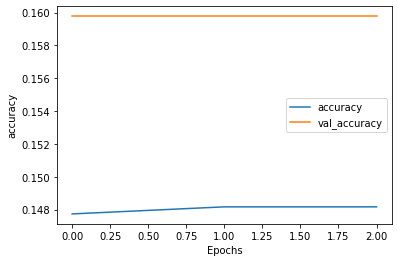

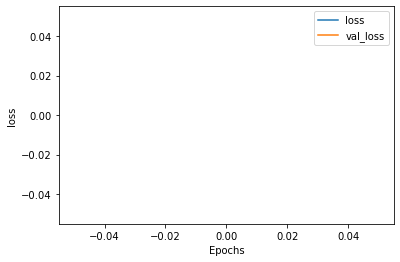

In [15]:
# Plot the loss and accuracy
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")